### Building your network

In [0]:
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import DenseNet121, ResNet50, MobileNetV2

## DenseNet121

  - Size: 33MB
  - Top-1 Accuracy: 0.750
  - Top-5 Accuracy: 0.923
  - Parameters: 8,062,504
  - Depth: 121

In [0]:
densenet_model = DenseNet121(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in densenet_model.layers])

# Getting output tensor of the last DenseNet201 layer that we want to include
x = layer_dict['relu'].output

# Stacking a new simple convolutional network on top of it    
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
custom_densenet_model = Model(densenet_model.input, x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_densenet_model.layers[:420]:
    layer.trainable = False

In [91]:
custom_densenet_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_44 (ZeroPadding2 (None, 70, 70, 3)    0           input_35[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_44[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [92]:
len(layer_dict)

427

## ResNet50

  - Size: 98MB
  - Top-1 Accuracy: 0.749
  - Top-5 Accuracy: 0.921
  - Parameters: 25,636,712
  - Depth: -

In [0]:
resnet_model = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

layer_dict = dict([(layer.name, layer) for layer in resnet_model.layers])

x = layer_dict['conv5_block3_out'].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

custom_resnet_model = Model(resnet_model.input, x)

for layer in custom_resnet_model.layers[:171]:
    layer.trainable = False

In [76]:
custom_resnet_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_33[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [77]:
len(layer_dict)

175

## MobileNetV2

  - Size: 14MB
  - Top-1 Accuracy: 0.713
  - Top-5 Accuracy: 0.901
  - Parameters: 3,538,984
  - Depth: 88

In [65]:
mobilenet_model = MobileNetV2(weights='imagenet',
                            include_top=False,
                            input_shape=(64,64,3))

layer_dict = dict([(layer.name, layer) for layer in mobilenet_model.layers])

x = layer_dict['out_relu'].output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(33, activation='softmax')(x)

custom_mobilenet_model = Model(mobilenet_model.input, x)

for layer in custom_mobilenet_model.layers[:150]:
    layer.trainable = False

In [66]:
custom_mobilenet_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_31[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
___________________________________________________________________________________________

In [67]:
len(layer_dict)

155

## Compile

In [0]:
from tensorflow.keras import optimizers

custom_densenet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

custom_resnet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

custom_mobilenet_model.compile(loss='categorical_crossentropy',
                               optimizer= optimizers.Adam(lr=1e-3),
                               metrics=['acc'])

### Data preprocessing
Using ImageDataGenerator to read images from directories

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/train"
validation_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/validation"

# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir, # Target directory
    target_size=(64, 64), #Resizes all images to 64 × 64
    batch_size=32,
    class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

Found 5077 images belonging to 33 classes.
Found 2789 images belonging to 33 classes.


### Fitting the model using a batch generator

In [80]:
history1 = custom_densenet_model.fit_generator(train_generator,
                                              steps_per_epoch=750,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=250)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
 53/750 [=>............................] - ETA: 2:41:44 - loss: 2.1487 - acc: 0.4116

KeyboardInterrupt: ignored

In [93]:
history2 = custom_mobilenet_model.fit_generator(train_generator,
                                              steps_per_epoch=750,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=250)

Epoch 1/10
159/750 [=====>........................] - ETA: 58:41 - loss: 1.2943 - acc: 0.6415WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 7500 batches). You may need to use the repeat() function when building your dataset.


KeyboardInterrupt: ignored

In [0]:
history3 = custom_mobilenet_model.fit_generator(train_generator,
                                              steps_per_epoch=750,
                                              epochs=10,
                                              validation_data=validation_generator,
                                              validation_steps=250)

### Saving the model

In [0]:
custom_densenet_model.save('/content/drive/My Drive/model_save/custom_densenet_model.h5')
custom_resnet_model.save('/content/drive/My Drive/model_save/custom_resnet_model.h5')
custom_mobilenet_model.save('/content/drive/My Drive/model_save/custom_mobilenet_model.h5')

### Displaying curves of loss and accuracy during training

## DenseNet121

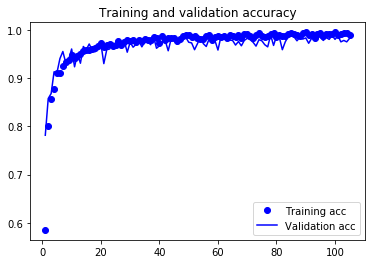

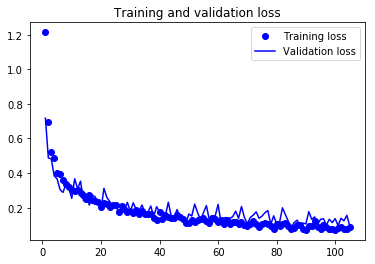

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('DenseNet121 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('DenseNet121 loss')
plt.legend()
plt.show()

#ResNet50

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('ResNet50 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('ResNet50 loss')
plt.legend()
plt.show()

#MobileNetV2

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('MobileNetV2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('MobileNetV2 loss')
plt.legend()
plt.show()

### Train the model on all samples (Training and Validation)

In [0]:
test_dir = "/content/drive/My Drive/Plant_leaf_split/dataset_split/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, # Target directory
    target_size=(64, 64), #Resizes all images to 64 × 64
    batch_size=32,
    class_mode='categorical')


Found 448 images belonging to 6 classes.


In [0]:
score1 = custom_densenet_model.evaluate_generator(test_generator, steps=250, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
score2 = custom_resnet_model.evaluate_generator(test_generator, steps=250, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
score3 = custom_mobilenet_model.evaluate_generator(test_generator, steps=250, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

In [0]:
print("DensNet121's acc: ",score1[1])
print("ResNet50's acc: ",score2[1])
print("MobileNetV2's acc: ",score3[1])

[0.06711883898824453, 0.9984375]
